
1.   Reed-solomon ec for test cases 7, 10, 13, 15
2.   Differentiate between v1 and v3 without depending on module size
3.   Identify that test case 2, 6, 14 are warped and straighten them into a square
4.   Decode v3 for test case 15, 16
5.   mighty finger has alphanumeric encoding type don't know if i should invest time in alterring to fit it






In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import reedsolo as rs
import os

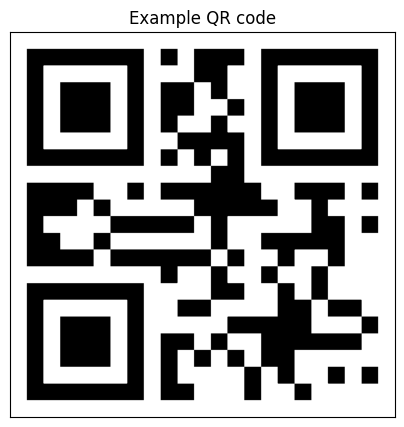

In [88]:
# Define the image file path
image_file_path = "preprocessed_images/output_19.png"

# Check if the image file exists
if not os.path.isfile(image_file_path):
    raise FileNotFoundError(f"The image file {image_file_path} does not exist.")

# Read the image file
try:
    img = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
except Exception as e:
    raise IOError(f"Unable to read the image file {image_file_path}. Error: {str(e)}")

# Apply a binary threshold to the image
_, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Display the image
fig = plt.figure(figsize=(5, 5))
plt.xticks([], [])
plt.yticks([], [])
plt.title('Example QR code')
plt.imshow(img, cmap='gray')

In [89]:
quiet_zone_ratio_map = {
    "preprocessed_images/output_1.png": 0.05,
    "preprocessed_images/output_2.png": 0.01,
    "preprocessed_images/output_3.png": 0.05,
    "preprocessed_images/output_4.png": 0.05,
    "preprocessed_images/output_5.png": 0.02,
    "preprocessed_images/output_6.png": 0.02,
    "preprocessed_images/output_7.png": 0.05,
    "preprocessed_images/output_8.png": 0.05,
    "preprocessed_images/output_9.png": 0.053,
    "preprocessed_images/output_10.png": 0.01,
    "preprocessed_images/output_11.png": 0.05,
    "preprocessed_images/output_12.png": 0.05,
    "preprocessed_images/output_13.png": 0.05,
    "preprocessed_images/output_14.png": 0.015,
    "preprocessed_images/output_15.png": 0.015,
    "preprocessed_images/output_16.png": 0.03,
    "preprocessed_images/output_17.png": 0.05,
    "preprocessed_images/output_18.png": 0.05,
    "preprocessed_images/output_19.png": 0.05,
}

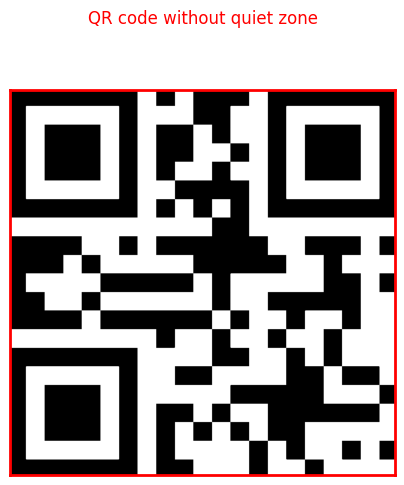

In [90]:
# Apply a binary threshold to segment the QR code
_, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Detect all contours in the thresholded image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Assume the largest contour represents the QR code
largest_contour = max(contours, key=cv2.contourArea)

# Get the bounding rectangle of the largest contour
x, y, w, h = cv2.boundingRect(largest_contour)

# Manually exclude the quiet zone by reducing the dimensions
# Here, we assume the quiet zone is a certain percentage of the overall size
quiet_zone_ratio = 0.05  # Adjust based on the estimated quiet zone size
new_x = int(x + quiet_zone_ratio * w)
new_y = int(y + quiet_zone_ratio * h)
new_w = int(w * (1 - 2 * quiet_zone_ratio))
new_h = int(h * (1 - 2 * quiet_zone_ratio))

# Crop the QR code region to remove the quiet zone
qr_no_quiet_zone = img[new_y:new_y+new_h, new_x:new_x+new_w]

# Plot the cropped QR code with a red border
fig = plt.figure(figsize=(5, 5))
plt.xticks([], [])
plt.yticks([], [])
plt.title('QR code without quiet zone', y=1.15, color='red')
plt.imshow(qr_no_quiet_zone, cmap='gray')
plt.gca().spines['top'].set_color('red')
plt.gca().spines['right'].set_color('red')
plt.gca().spines['bottom'].set_color('red')
plt.gca().spines['left'].set_color('red')
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.show()


### QR Code Cropping Algorithm


This code follows the edges of a QR code within an image and crops it, leaving the quiet zone out:


1. **Finding Boundaries**:

- It cycles through the rows and columns of the picture to locate the first and last rows/columns with non-whitespace pixels that denote the beginning and the end of the QR code.


2. **Aligning Rows and Columns**: 

- It makes the start and end rows/columns to be aligned by taking the maximum of their values.


3. **Ensuring Divisibility by 21**: 

- It ensures that the difference of start and end rows/columns is a multiple of 21, since each QR code module is usually of 21 pixels.


4. **Cropping**:

- It outputs crop region coordinates.


In [12]:
# gotta find a new way to get the qr without the quiet zone
start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img.shape[1] - col_index
            break
    if end_col != -1:
        break
# Align the start and end rows and columns
start_row, start_col = max(start_row, start_col), max(start_row, start_col)
end_row, end_col = max(end_row, end_col), max(end_row, end_col)

# Ensure the difference between the start and end is divisible by 21
diff_row = end_row - start_row
diff_col = end_col - start_col

if diff_row % 21 != 0:
    end_row -= diff_row % 21
if diff_col % 21 != 0:
    end_col -= diff_col % 21


print(start_row, end_row, start_col, end_col)
# 44 968 44 968

0 1008 0 1008


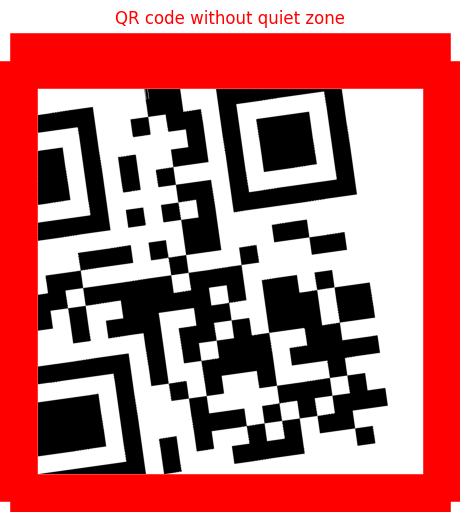

In [13]:
qr_no_quiet_zone = img[start_row: end_row, start_col: end_col]
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
fig.get_axes()[0].spines[:].set_color('red');
fig.get_axes()[0].spines[:].set_linewidth(40);
fig.get_axes()[0].spines[:].set_position(("outward", 20))
plt.title('QR code without quiet zone', y = 1.15, color='red');
plt.imshow(qr_no_quiet_zone, cmap='gray');

### QR Code Grid Cell Partitioning

This code divides the QR code region (excluding the quiet zone) into a grid of smaller cells:

1. **Grid Cell Calculation**:
   - `grid_cells_num` is set to 21, determining the number of cells along each dimension.
   - `grid_cell_size` is calculated based on the QR code region dimensions and the desired number of cells.

2. **Reshaping into Grid Cells**:
   - The QR code region is reshaped into a grid of cells.
   - Each cell's dimensions are determined by `grid_cell_size`, and the grid size is determined by `grid_cells_num`.


In [ ]:

grid_cells_num = 21
grid_cell_size = round(math.sqrt((end_row - start_row)**2 / (grid_cells_num**2)))

# ...into grid cells
qr_cells = qr_no_quiet_zone.reshape((
    grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size,
)).swapaxes(1, 2)
print(qr_cells.shape)

### QR Code Orientation Correction

This cell contains a function `correct_orientation()` designed to correct the orientation of a QR code based on characteristic patterns found in its grid cells:

1. **Pattern Check Function**:
   - The `check_pattern()` function verifies if a given set of grid cells matches a predefined pattern commonly found in QR codes.

2. **Rotation Function**:
   - The `rotate_image()` function rotates the QR code image by the specified number of degrees using NumPy's rotation function.

3. **Orientation Correction**:
   - The `correct_orientation()` function examines specific patterns in the grid cells' corners to determine the QR code's orientation.
   - Based on the pattern matches, it decides whether to rotate the QR code by 90, 180, or 270 degrees to correct its orientation.

4. **Applying Correction**:
   - The function returns the corrected QR code grid cells after orientation adjustment.

This approach automates the orientation correction process based on recognizable patterns within the QR code grid cells, ensuring that the QR code is correctly aligned for further processing or decoding.


In [ ]:
# Correct the orientation of the rotated qr code
def check_pattern(cells):
    pattern = [0, 255, 0, 0, 0, 255, 0]  # 1:1:3:1:1 pattern
    result = all(np.mean(cell) == pat for cell, pat in zip(cells, pattern))
    print(f"Pattern check result: {result}")
    return result

def rotate_image(image, degrees):
    print(f"Rotating image by {degrees} degrees")
    return np.rot90(image, degrees // 90)

def correct_orientation(qr_cells, grid_cell_num):

    # bottom_right corner pattern check
    bottom_right_row = qr_cells[grid_cells_num-4, -7:]  # Check the last 7 cells in the row indexed grid_cells_num - 4
    bottom_right_col = qr_cells[-7:, grid_cells_num-4]  # Check the last 7 cells in the column indexed grid_cells_num - 4

    # Top right corner pattern check
    top_right_row = qr_cells[3, -7:]  # Check the last 7 cells in the third row
    top_right_col = qr_cells[:7, grid_cells_num-4]  # Check the first 7 cells in the grid_cells_num - 4 column

    # Bottom left corner pattern check
    bottom_left_row = qr_cells[grid_cells_num-4, :7] # Check the first 7 cells of row indexed by grid_cells_num - 4
    bottom_left_col = qr_cells[-7:, 3] # Check the last 7 cells of column indexed by 3


    if not(check_pattern(bottom_right_row) and check_pattern(bottom_right_col)):
        print("Correct")
        return qr_cells  # QR code is in the right orientation

    elif check_pattern(top_right_row) and check_pattern(top_right_col) and check_pattern(bottom_left_row) and check_pattern(bottom_left_col):
        print("Rotating QR code by 180 degrees")
        return rotate_image(qr_cells, 180)  # Rotate 180 degrees

    elif check_pattern(top_right_row) and check_pattern(top_right_col):
        print("Rotating QR code by 270 degrees")
        return rotate_image(qr_cells, 270)  # Rotate 270 degrees

    elif check_pattern(bottom_left_row) and check_pattern(bottom_left_col):
        print("Rotating QR code by 90 degrees")
        return rotate_image(qr_cells, 90)  # Rotate 90 degrees

corrected_qr = correct_orientation(qr_cells, grid_cells_num)



In [ ]:
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(corrected_qr[i][j], cmap="gray", vmin=0, vmax=255)
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        col.spines[:].set_color('red')

### Converting QR Code to Numeric Representation

In [ ]:
qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
for i, row in enumerate(corrected_qr):
    for j, cell in enumerate(row):
        qr_cells_numeric[i, j] = (np.median(cell) // 255)

print(qr_cells_numeric)

## Information extraction

![Meaning of format information.](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/QR_Format_Information.svg/640px-QR_Format_Information.svg.png)
> *Meaning of format information.*

### Error correction level

In [ ]:
# We want row #8 or we can get it from the locator on the bottom left which is located at row 19 to 21 and col 8
# qr_cells_numeric[8]
# qr_cells_numeric[19:21, 8]
print("ECL bits:", qr_cells_numeric[19:21, 8])

### Error Correction Level Extraction

This cell extracts the error correction level (ECL) from the bottom left locator of the QR code. Here's the process:

1. **Error Correction Level Encoding**: The error correction level (ECL) information is encoded within the last two bits of the format information in the bottom left locator of the QR code. These two bits determine the error correction level according to the following encoding:
   - Level L (Low): [11]
   - Level M (Medium): [10]
   - Level Q (Quartile): [01]
   - Level H (High): [00]

2. **Extraction from Bottom Left Locator**: The code extracts the last two bits from the rows 19 and 20 and column 8 of the `qr_cells_numeric` array, corresponding to the bottom left locator of the QR code.

3. **Inversion**: The extracted bits are inverted because the standard uses '1's for black and '0's for white, whereas in image processing, it's the opposite. Hence, the inversion is performed to match the encoding standard.



In [ ]:
ecl = [int(not(c)) for c in qr_cells_numeric[19:21, 8]]  # We'll read the ecl from the bottom locator instead
print(ecl)

### Mask Pattern Extraction

This cell defines a dictionary of mask patterns and their corresponding formulas for applying masks to QR code data. It also extracts the mask pattern from the QR code image based on specific rows and columns:

1. **Mask Pattern Dictionary**: The `MASKS` dictionary contains mask patterns as keys and lambda functions as values. These functions determine whether a cell should be masked based on its position within the QR code grid.

2. **Extraction Process**: The code extracts the mask pattern from the three bits before the error correction level (ECL) in column 8 of the QR code. It reads these bits from rows 18, 17, and 16 of the `qr_cells_numeric` array.


In [ ]:
# Dictionary of all masks and their equivalent formulae
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
    "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
    "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

# Same row as above, the three cells after the ecl cells (converted to a string)
# We'll read the mask pattern from the three bits before the ecl in col 8
mask = [int(not(c)) for c in qr_cells_numeric[18:15:-1, 8]] # 18:15:-1 is the same as 18, 17, 16 as we're going backwards
mask_str = ''.join([str(c) for c in mask])
print(mask_str)

### Format error correction

In [ ]:
# Same row as above, but we want cells #5 and #7 (#6 is always set to 0),
#  followed by column #8 from cell #0 in it to cell #7 (and skipping #6)
# fec = []
# fec.append(qr_cells_numeric[8, 5])
# fec.append(qr_cells_numeric[8, 7])
# fec.extend(qr_cells_numeric[0:6, 8])
# fec.extend(qr_cells_numeric[7:9, 8])
# fec = [int(not(c)) for c in fec]
# print(fec)

# We'll get #15, #14 from col 8 since #13 is always black
# We'll also get row 8 from last col to col 13
fec = []
fec.append(qr_cells_numeric[15, 8])
fec.append(qr_cells_numeric[14, 8])
fec.extend(qr_cells_numeric[8, 13:21][::-1])  # Reverse to get from col 20 to col 13
fec = [int(not(c)) for c in fec]
print(fec)


In [ ]:
# So in total we have the following 15 bits of format info from our QR code
print(ecl, mask, fec)

In [ ]:
# Let's cross-check with our example
# _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
# for i, row in enumerate(axes):
#     for j, col in enumerate(row):

#         col.get_xaxis().set_visible(False)
#         col.get_yaxis().set_visible(False)
#         if (i == 8 and j <= 8) or (i <= 8 and j == 8):
#             if (i != 6) and (j != 6):
#                 col.imshow(corrected_qr[i][j], cmap="gray", vmin=0, vmax=255)
#                 col.spines[:].set_color('red')
#                 continue
#         col.imshow(corrected_qr[i][j], cmap="gray", vmin=-1275, vmax=510)


# Plot the new format info
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):

        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        if (i in range(15, grid_cells_num) and j == 8) or (i == 8 and j in range(14, grid_cells_num)):
            col.imshow(corrected_qr[i][j], cmap="gray", vmin=0, vmax=255)
            col.spines[:].set_color('red')
            continue
        col.imshow(corrected_qr[i][j], cmap="gray", vmin=-1275, vmax=510)

In [ ]:
# However..... You need to XOR that with the "format mask": 101010000010010
# ecl[0] ^= 1
mask[0] ^= 1
mask[2] ^= 1
fec[5] ^= 1
fec[8] ^= 1

# And now we print...
print(ecl, mask, fec)

## Data extraction

![Message placement within a Ver 1 QR symbol (21×21).](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/QR_Character_Placement.svg/640px-QR_Character_Placement.svg.png)
> *Message placement within a Ver 1 QR symbol (21×21). Example from wikipedia, encoded QR message is www.wikipedia.org*

### Masking Function Definition

This cell defines a function `apply_mask()` for applying masking to the QR code data. Here's a summary:

1. **Function Parameters**: The function takes `data_start_i` and `data_start_j` as coordinates of the first cell in the data region of the QR code, and `direction` as the masking direction.

2. **Masking Logic**: The function computes offsets for each cell based on the specified direction and determines whether each cell should be masked according to the mask pattern.

### Masking Directions and Offsets

- **UP**: Upward masking direction.
- **UP_ENC**: Upward masking direction for encoding.
- **DOWN**: Downward masking direction.
- **CW**: Clockwise masking direction.
- **CCW**: Counter-clockwise masking direction.


In [ ]:
# Before we proceed, let's write a function for masking to make our lives easier
UP, UP_ENC, DOWN, CW, CCW = range(5)  # A rather old-fashioned pythonic "Enum"

def apply_mask(data_start_i, data_start_j, direction):
    '''
    data_start_i/j represent the first cell's coords in its respective direction
    direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
    '''
    result = []
    row_offsets = []
    col_offsets = []
    if (direction in [UP, UP_ENC]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == DOWN):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]

    for i, j in zip(row_offsets, col_offsets):
        cell = qr_cells_numeric[data_start_i+i, data_start_j+j]
        result.append(int(cell if MASKS[mask_str](data_start_i+i, data_start_j+j) else not cell))

    return result[:4] if direction == UP_ENC else result

### Data encoding


- **0001**: Numeric encoding (10 bits per 3 digits)
- **0010**: Alphanumeric encoding (11 bits per 2 characters)
- **0100**: Byte encoding (8 bits per character)
- **1000**: Kanji encoding (13 bits per character)
- **0011**: Structured append (used to split a message across multiple QR symbols)
- **0111**: ECI (Extended Channel Interpretation) (used to specify character encoding)
- **0101**: FNC1 in first position (used in GS1 application identifiers)
- **1001**: FNC1 in second position (used in GS1 application identifiers)
- **0000**: Termination (used to indicate the end of a message)


In [ ]:
enc = apply_mask(grid_cells_num-1, grid_cells_num-1, UP_ENC)
print(enc)

### Data length

In [ ]:
length = apply_mask(grid_cells_num - 3, grid_cells_num - 1, UP)
print(length)

### Data extraction and Error Correction
![Message placement within a Ver 1 QR symbol (21×21).](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/QR_Character_Placement.svg/640px-QR_Character_Placement.svg.png)

In [ ]:
data_starting_indices = [
    [grid_cells_num-7,  grid_cells_num-1,  UP],    #    w    /     H
    [grid_cells_num-11, grid_cells_num-1,  CCW],   #    w    /     e
    [grid_cells_num-10, grid_cells_num-3,  DOWN],  #    w    /     l
    [grid_cells_num-6,  grid_cells_num-3,  DOWN],  #    .    /     l
    [grid_cells_num-2,  grid_cells_num-3,  CW],    #    w    /     o
    [grid_cells_num-3,  grid_cells_num-5,  UP],    #    i    /     ,
    [grid_cells_num-7,  grid_cells_num-5,  UP],    #    k    /  (space)
    [grid_cells_num-11, grid_cells_num-5,  CCW],   #    i    /     Q
    [grid_cells_num-10, grid_cells_num-7,  DOWN],  #    p    /     R
    [grid_cells_num-6,  grid_cells_num-7,  DOWN],  #    e    /  (space)
    [grid_cells_num-2,  grid_cells_num-7,  CW],    #    d    /     W
    [grid_cells_num-3,  grid_cells_num-9,  UP],    #    i    /     o
    [grid_cells_num-7,  grid_cells_num-9,  UP],    #    a    /     r
    [grid_cells_num-11, grid_cells_num-9,  UP],    #    .    /     l
    [grid_cells_num-16, grid_cells_num-9,  UP],    #    o    /     d
    [grid_cells_num-20, grid_cells_num-9,  CCW],   #    r    /     !
    [grid_cells_num-19, grid_cells_num-11, DOWN],  #    g    /     1
    [grid_cells_num-14, grid_cells_num-11, DOWN],  # End of message (Terminator)
    [grid_cells_num-12, grid_cells_num-11, DOWN],  # E1
    [grid_cells_num-8,  grid_cells_num-11, DOWN],  # E2
    [grid_cells_num-4,  grid_cells_num-11, DOWN],  # E3
    [grid_cells_num-9,  grid_cells_num-13, UP],    # E4
    [grid_cells_num-12, grid_cells_num-16, DOWN],  # E5
    [grid_cells_num-9,  grid_cells_num-18, UP],    # E6
    [grid_cells_num-12, grid_cells_num-20, DOWN],  # E7
]

In [ ]:
message_bits = []
message_bits.extend(enc)
message_bits.extend(length)
extracted_data_no_error_correction = ''
for a, b, d in data_starting_indices:  # For each starting index and direction
    bits = apply_mask(a, b, d)  # Extract the bits per the indexed QR code symbol
    bit_string = ''.join([str(bit) for bit in bits])  # Convert to string of bits
    alpha_char = chr(int(bit_string, 2))  # Convert binary to int, then to a char
    if bit_string[:4] == "0000":  # If the first 4 bits are 0s, this is the END
        print(f'{bit_string[:4]}...         = NULL TERMINATOR (END Symbol, SKIP!)')
        message_bits.extend(bits[:4])  # Append only the four bits
    else:  # If not the END symbol, append full set of bits
        message_bits.extend(bits)
        extracted_data_no_error_correction += alpha_char
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')

print(f'\ni.e., the data and ECCs in the QR code as-is are "{extracted_data_no_error_correction}"')

# use the reedsolo library to decode the message and correct any errors
# For every 8 bits in the extracted message, convert to a byte
extracted_data_bytes = [int(''.join([str(bit) for bit in message_bits[i:i+8]]), 2) for i in range(0, len(message_bits), 8)]
reed_solomon = rs.RSCodec(nsym=10) # Create a Reed-Solomon codec object with 7 error correction bytes
print(f'\nDecoding the message using Reed-Solomon error correction...')
try:
    decoded_data_bytes = reed_solomon.decode(extracted_data_bytes)  # Decode the message
    decoded_data = ''.join([chr(byte) for byte in decoded_data_bytes])  # Convert bytes to characters
    print(f'The decoded message is: "{decoded_data}"')
except rs.ReedSolomonError as e:
    print(f'Error decoding the message: {str(e)}')

In [ ]:
# Extract data without error correction
extracted_data_no_error_correction = ""
message_bits = []

# Loop through data starting indices and apply mask
for a, b, d in data_starting_indices:
    bits = apply_mask(a, b, d)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    if bit_string[:4] == "0000":
        message_bits.extend(bits[:4])
    else:
        message_bits.extend(bits)
        extracted_data_no_error_correction += alpha_char

# Decode Reed-Solomon for error correction
message_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]
rsc = rs.RSCodec(nsym=12)  # Initialize Reed-Solomon codec with appropriate parameters
corrected_message_bytes = rsc.decode(message_bytes)[0]

# Convert bytes to string
corrected_data = corrected_message_bytes.decode(encoding="iso-8859-1")

# Print or use corrected data as needed
print("Corrected data:", corrected_data)
